# Introduction 

This Notebook will do the following things :
1. Create a portfolio based on Markowitz Model with Integer Optimization
2. Create a test on the portfolio for each 2 year

# Workflow 
0. Import useful package such as Numpy, Pandas, yfinance, scipy.optimize, matplotlib and seaborn.
1. Filter all the stocks with stocks that currently has positive mean return and has the same date.
2. Create portfolio.
3. Testing the portfolio that has been made.

# Packages

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import yfinance as yf
from scipy.optimize import minimize
import seaborn as sn

# Initialize First Pick

In [2]:
stock = ['BBCA.JK', 'BMRI.JK', 'BBNI.JK', 'BBTN.JK', 'HRUM.JK', 'SMGR.JK', 'TLKM.JK', 'UNVR.JK', 'ASII.JK']
year = 2022
ds = str(year-1)+'-12-01'
df = pd.DataFrame(columns=stock)
for i in stock :
    temp = yf.Ticker(i).history(period = '1y', start = ds, interval = '1mo',actions=False).dropna()[['Close']][:-1]
    log_return = np.log(temp['Close']/temp['Close'].shift(1)).dropna()
    df[i] = log_return
curr_ = df.describe().T
curr_ = curr_[curr_['mean']>0]
curr_stock = set(curr_.index)

In [3]:
year = 2020
ds = str(year-2)+'-12-01'
de = str(year+1)+'-12-01'
df = pd.DataFrame(columns=curr_stock)
for i in stock :
    temp = yf.Ticker(i).history(period = '2y', start = ds, end=de, interval = '1mo',actions=False).dropna()[['Close']]
    log_return = np.log(temp['Close']/temp['Close'].shift(1)).dropna()
    df[i] = log_return
prev_ = df.describe().T
prev_ = prev_[prev_['mean']>0]
prev_stock = set(prev_.index)

In [4]:
stock = list(prev_stock)
#stock = list(curr_stock & prev_stock)
year = 2020
ds = str(year-3)+'-12-01'
de = str(year+1)+'-12-01'
df = pd.DataFrame(columns=stock)
for i in stock :
    temp = yf.Ticker(i).history(period = '2y', start = ds ,end =de ,interval = '1mo',actions=False).dropna()[['Close']]
    if temp.shape[0] == 49:
        log_return = np.log(temp['Close']/temp['Close'].shift(1)).dropna()
        df[i] = log_return

In [5]:
mu = df.mean().values
C = df.cov().values
mu = np.append(5.9/1200, mu)
C = np.vstack((np.zeros(C.shape[1]), C))
C = np.hstack((np.column_stack([1]+[0]*(C.shape[0 ]-1)).T, C))
C

array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  4.10121245e-02, -3.30138024e-04,
         1.78022334e-03,  8.91073735e-04],
       [ 0.00000000e+00, -3.30138024e-04,  7.34234570e-03,
         3.50410879e-03,  1.71517473e-03],
       [ 0.00000000e+00,  1.78022334e-03,  3.50410879e-03,
         3.12577181e-03,  7.35621772e-04],
       [ 0.00000000e+00,  8.91073735e-04,  1.71517473e-03,
         7.35621772e-04,  4.79982980e-03]])

In [6]:
def objective(weights): 
    weights = np.array(weights)
    return weights.dot(C).dot(weights.T)

# The constraints
cons = (
    {"type":"eq", "fun": lambda x: np.sum(x)-1}, 
    #{"type": "ineq", "fun": lambda x: np.sum(mu*x)-0.03}
        )

bounds = tuple((0,1) for x in range(mu.shape[0]))
guess = [1./mu.shape[0] for x in range(mu.shape[0])]
optimized_results = minimize(objective, guess, method = "SLSQP", bounds=bounds, constraints=cons)
x_ = np.round(optimized_results.x,4)

In [7]:
np.sum(np.round(x_,5))

1.0001000000000002

In [8]:
port_ = dict(zip(['bond'] + stock,np.round(x_,5)))
port = dict()
for (key,value) in port_.items():
    if value >0 : 
        port[key] = value
port

{'bond': 0.0023, 'HRUM.JK': 0.0194, 'BBCA.JK': 0.6145, 'TLKM.JK': 0.3639}

In [9]:
start = 7e7
budget_ = dict()
for (key,value) in port.items():
    if value >0 : 
        budget_[key] = value*start
budget_

{'bond': 161000.0,
 'HRUM.JK': 1358000.0,
 'BBCA.JK': 43015000.0,
 'TLKM.JK': 25473000.0}

In [10]:
budget = pd.DataFrame.from_dict(data= budget_, orient= 'index').T
budget.rename(index={0: 'Total Spread'}, inplace= True)
budget

,bond,HRUM.JK,BBCA.JK,TLKM.JK
Total Spread,161000.0,1358000.0,43015000.0,25473000.0


In [11]:
expense = pd.DataFrame(columns=port.keys(), )
for item in port.keys():
    if item != 'bond': 
        temp = yf.Ticker(item).history(period = '1d', interval = '1mo',actions=False)
        expense[item] = temp['Close']*100 #1 lot
expense['bond'] = budget_['bond']
expense.rename(index ={expense.index[0]: str('Closing ' + str(expense.index[0]).split(' ')[0])}, inplace= True)
expense

,bond,HRUM.JK,BBCA.JK,TLKM.JK
Date,,,,
Closing 2023-06-20,161000.0,141000.0,905000.0,399000.0


In [12]:
qty = pd.concat([expense,budget])
temp_ = pd.DataFrame(np.round(qty.iloc[1] / qty.iloc[0],0)).T
temp_.rename(index={0: 'Total Lot'}, inplace= True)
qty = pd.concat([qty, temp_])
spend = pd.DataFrame(np.round(qty.iloc[2] * qty.iloc[0],0)).T
finale = pd.concat([qty, spend])
finale.rename(index={0: 'Total Spending'}, inplace= True)
finale

,bond,HRUM.JK,BBCA.JK,TLKM.JK
Closing 2023-06-20,161000.0,141000.0,905000.0,399000.0
Total Spread,161000.0,1358000.0,43015000.0,25473000.0
Total Lot,1.0,10.0,48.0,64.0
Total Spending,161000.0,1410000.0,43440000.0,25536000.0


In [13]:
finale.sum(axis = 1)

Closing 2023-06-20     1606000.0
Total Spread          70007000.0
Total Lot                  123.0
Total Spending        70547000.0
dtype: float64

In [14]:
print(f'return :', x_.dot(mu)*100, '%')
print(f'risk :', x_.dot(C).dot(x_)*100, '%')
print(f'Total Money :',finale.sum(axis=1)[-1])
print(f'Total Idle Money :', start - finale.sum(axis=1)[-1])

return : 0.8230813125100551 %
risk : 0.2220678580176938 %
Total Money : 70547000.0
Total Idle Money : -547000.0


In [15]:
finale.columns

Index(['bond', 'HRUM.JK', 'BBCA.JK', 'TLKM.JK'], dtype='object')

In [16]:
df[finale.columns[1:]]

,HRUM.JK,BBCA.JK,TLKM.JK
Date,,,
2018-01-01,0.476083,0.036979,-0.106863
2018-02-01,0.029853,0.019608,0.002503
2018-03-01,-0.223143,0.005379,-0.105361
2018-04-01,-0.060625,-0.052876,0.061931
2018-05-01,0.232475,0.034375,-0.084404
2018-06-01,-0.264224,-0.055475,0.072158
2018-07-01,0.236535,0.080490,-0.049190
2018-08-01,-0.124704,0.063464,-0.022664
2018-09-01,-0.064539,-0.026559,0.042082


In [17]:
test = pd.DataFrame(columns = finale.columns[1:])
for i in finale.columns :
    temp = yf.Ticker(i).history(period = '1y', start = '2021-12-31', interval = '1mo',actions=False).dropna()[['Close']][:-1]
    log_return = np.log(temp['Close']/temp['Close'].shift(1)).dropna()
    test[i] = log_return

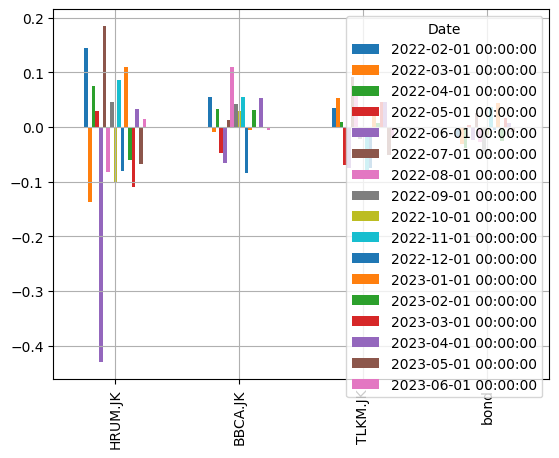

In [18]:
test.T.plot.bar()
plt.grid(True)
plt.show()

In [19]:
ports = [x_[i] for i in range(len(x_)) if x_[i]>0]
ports

[0.0023, 0.0194, 0.6145, 0.3639]

In [20]:
test['total_return'] = test.dot(ports) + 5.9/1200
test

,HRUM.JK,BBCA.JK,TLKM.JK,bond,total_return
Date,,,,,
2022-02-01,0.144355,0.054240,0.035174,-0.018168,0.021304
2022-03-01,-0.137321,-0.009360,0.053825,-0.031567,0.026007
2022-04-01,0.074275,0.033844,0.008696,-0.039032,-0.003116
2022-05-01,0.029917,-0.047253,-0.069457,0.003282,-0.037418
2022-06-01,-0.429973,-0.066691,-0.074643,-0.023447,-0.051767
2022-07-01,0.184919,0.013699,0.091831,0.026011,0.071503
2022-08-01,-0.081851,0.109434,0.075121,-0.028199,0.042752
2022-09-01,0.045985,0.041797,-0.022174,-0.049556,-0.025826
2022-10-01,-0.100379,0.028820,-0.015819,-0.014227,-0.009653


In [21]:
test.columns[:-1]

Index(['HRUM.JK', 'BBCA.JK', 'TLKM.JK', 'bond'], dtype='object')

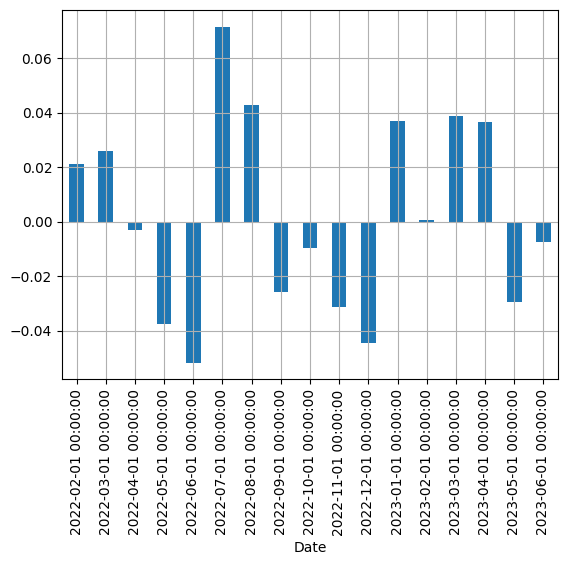

In [22]:
test.total_return.plot.bar()
plt.grid(True)
plt.show()

In [23]:
finale.to_csv(str('IHSG '+finale.index[0].split(' ')[1]+'.csv'))